In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.layers import Cropping2D, UpSampling2D
from keras.utils import to_categorical
#from keras.utils import np_utils

# Required for loss function
import math
#from tensorflow.python.keras import losses

#from tensorflow.contrib.keras.layers import Cropping2D

import tensorflow as tf

from unet_utilz import *
from data_augmentation import *

Using TensorFlow backend.


In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
# Original size = 572*572
LABEL_CLASS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [10]:
# Import the data

# Path for Linux
#TRAIN_PATH = '/home/ziheng/UNet/dataset_lab/train/'
#TEST_PATH = '/home/ziheng/UNet/dataset_lab/test/'

# Path for Windows
TRAIN_PATH = 'F:\\MA\\data\\Swain_lab\\DISCO_result\\str515_GFP_006\\train\\'
TEST_PATH = 'F:\\MA\\data\\Swain_lab\\DISCO_result\\str515_GFP_006\\test\\'

# Get train and test IDs
X_train_ids = next(os.walk(TRAIN_PATH + 'in/'))[2]
Y_train_ids = next(os.walk(TRAIN_PATH + 'out-cell/'))[2]

X_test_ids = next(os.walk(TEST_PATH + 'in/'))[2]
Y_test_ids = next(os.walk(TEST_PATH + 'out/'))[2]

In [11]:
# Get and resize train images and masks

# X: original images, Y: masks
X_train = np.zeros((len(X_train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
Y_train = np.zeros((len(Y_train_ids), IMG_HEIGHT, IMG_WIDTH, LABEL_CLASS), dtype=np.bool)

X_test = np.zeros((len(X_test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
Y_test = np.zeros((len(Y_test_ids), IMG_HEIGHT, IMG_WIDTH, LABEL_CLASS), dtype=np.bool)

print('Getting and resizing train images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(X_train_ids), total=len(X_train_ids)):
    
    img = imread(TRAIN_PATH + 'in/' + id_)
    X_train[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH, norm = False, rescale = True)
    
    
print('Getting and resizing train masks ... ')

for n, id_ in tqdm(enumerate(Y_train_ids), total=len(Y_train_ids)):
    
    mask = imread(TRAIN_PATH + 'out-cell/' + id_)
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    Y_train[n] = mask
    
    
# Get and resize test images
#sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(X_test_ids), total=len(X_test_ids)):

    img = imread(TEST_PATH + 'in/' + id_)
    X_test[n] = pre_process(img, IMG_HEIGHT, IMG_WIDTH, norm = False, rescale = True)
    
print('Getting and resizing test masks ... ')

for n, id_ in tqdm(enumerate(Y_test_ids), total=len(Y_test_ids)):
    
    mask = imread(TEST_PATH + 'out-cell/' + id_)
    mask = to_categorical(mask, LABEL_CLASS) # Generate binary masks (one hot encoding)
    # Resizing need to be done AFTER one-hot encoding!!!!!!!
    mask = pre_process(mask, IMG_HEIGHT, IMG_WIDTH, mask = True)
    Y_test[n] = mask
        
print('Done!')

Getting and resizing train images ... 


100%|███████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 242.34it/s]


Getting and resizing train masks ... 


100%|███████████████████████████████████████████████████████████████████████████████| 170/170 [00:00<00:00, 256.31it/s]


Getting and resizing test images ... 


100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 489.80it/s]


Getting and resizing test masks ... 


100%|███████████████████████████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 280.31it/s]


Done!


In [5]:
# Data augmentation: training data will be doubled
X_train_aug, Y_train_aug = augmentation(X_train, Y_train) #default flip is horizontal, vertical only for Swain lab
Y_train_aug = Y_train_aug.astype(bool)

In [6]:
print(X_train_aug.shape)
print(Y_train_aug.shape)

(108, 128, 128, 1)
(108, 128, 128, 3)


106


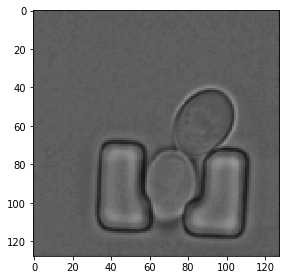

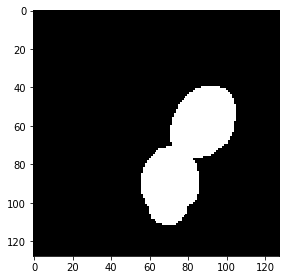

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(X_train_aug)-1)
print(ix)
mask_category = 2 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_train_aug[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(Y_train_aug[ix,:,:,mask_category])
plt.show()

61


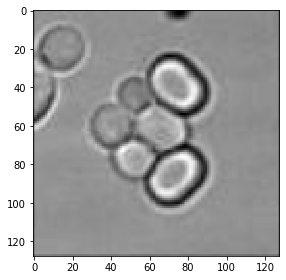

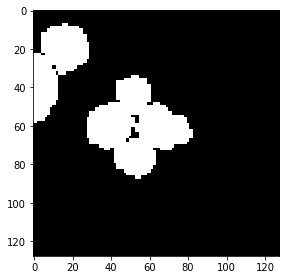

In [12]:
# Check if test data looks all right
ix = random.randint(0, len(X_test_ids)-1)
print(ix)
mask_category = 2 # Choose the mask nummer 0,1,2
imshow(np.reshape(X_test[ix], (IMG_WIDTH, IMG_HEIGHT)))
plt.show()
imshow(Y_test[ix,:,:,mask_category]) 
plt.show()

In [9]:
# Random validation split 20%
X_train, X_val, Y_train, Y_val = train_test_split(X_train_aug, Y_train_aug, test_size=0.2, random_state=42)

In [13]:
# Validation without data augmentation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [14]:
X_train.shape

(136, 128, 128, 1)

In [15]:
X_val.shape

(34, 128, 128, 1)

In [16]:
# Build U-Net model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))

# Preprocess is conducted directly in dataset
#s = Lambda(lambda x: x / 255) (inputs)
s = inputs

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

###################

#u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = UpSampling2D(size=(2, 2))(c5)

ch, cw = get_crop_shape(c4, u6)
crop_c4 = Cropping2D(cropping=(ch,cw))(c4)

u6 = concatenate([u6, crop_c4]) # Need to crop c4 from 64 to 56
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)


#u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = UpSampling2D(size=(2, 2))(c6)

ch, cw = get_crop_shape(c3, u7)
crop_c3 = Cropping2D(cropping=(ch,cw))(c3)

u7 = concatenate([u7, crop_c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)


#u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = UpSampling2D(size=(2, 2))(c7)

ch, cw = get_crop_shape(c2, u8)
crop_c2 = Cropping2D(cropping=(ch,cw))(c2)

u8 = concatenate([u8, crop_c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)


#u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = UpSampling2D(size=(2, 2))(c8)

ch, cw = get_crop_shape(c1, u9)
crop_c1 = Cropping2D(cropping=(ch,cw))(c1)

u9 = concatenate([u9, crop_c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(filters=LABEL_CLASS, kernel_size=(1, 1), activation='softmax') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss ='binary_crossentropy', metrics = [dice_loss, 'accuracy', IoU])
model.compile(optimizer='adam', loss = bce_dice_loss, metrics = [dice_loss, 'accuracy'])
#model.compile(optimizer='adam', loss = IoU_loss, metrics = [IoU, dice_loss, 'accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)    

conv2d_15 (Conv2D)              (None, 64, 64, 32)   27680       concatenate_3[0][0]              
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 64, 64, 32)   0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 64, 64, 32)   9248        dropout_8[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, 128, 128, 32) 0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
cropping2d_4 (Cropping2D)       (None, 128, 128, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
concatenat

In [17]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-swain-unet.h5', verbose=1, save_best_only=True)
history = model.fit(X_train, Y_train, validation_data=[X_val, Y_val], batch_size=8, epochs=50, 
                    callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 136 samples, validate on 34 samples
Epoch 1/50
136/136 [==============================] - ETA: 1:06 - loss: 2.2100 - dice_loss: 0.6131 - acc: 0.388 - ETA: 40s - loss: 2.3977 - dice_loss: 0.4080 - acc: 0.604 - ETA: 30s - loss: 2.2797 - dice_loss: 0.3243 - acc: 0.69 - ETA: 24s - loss: 1.9922 - dice_loss: 0.3080 - acc: 0.73 - ETA: 20s - loss: 1.7696 - dice_loss: 0.2922 - acc: 0.75 - ETA: 17s - loss: 1.6252 - dice_loss: 0.2770 - acc: 0.77 - ETA: 15s - loss: 1.5253 - dice_loss: 0.2732 - acc: 0.79 - ETA: 13s - loss: 1.4448 - dice_loss: 0.2597 - acc: 0.80 - ETA: 11s - loss: 1.4020 - dice_loss: 0.2693 - acc: 0.79 - ETA: 9s - loss: 1.3740 - dice_loss: 0.2639 - acc: 0.8060 - ETA: 8s - loss: 1.3360 - dice_loss: 0.2590 - acc: 0.812 - ETA: 6s - loss: 1.2985 - dice_loss: 0.2518 - acc: 0.818 - ETA: 5s - loss: 1.2654 - dice_loss: 0.2475 - acc: 0.821 - ETA: 3s - loss: 1

136/136 [==============================] - ETA: 18s - loss: 0.4267 - dice_loss: 0.1238 - acc: 0.91 - ETA: 17s - loss: 0.4291 - dice_loss: 0.1237 - acc: 0.91 - ETA: 16s - loss: 0.4233 - dice_loss: 0.1227 - acc: 0.91 - ETA: 14s - loss: 0.4144 - dice_loss: 0.1203 - acc: 0.91 - ETA: 13s - loss: 0.4098 - dice_loss: 0.1195 - acc: 0.91 - ETA: 12s - loss: 0.4025 - dice_loss: 0.1185 - acc: 0.91 - ETA: 11s - loss: 0.4016 - dice_loss: 0.1178 - acc: 0.92 - ETA: 10s - loss: 0.3971 - dice_loss: 0.1162 - acc: 0.92 - ETA: 9s - loss: 0.4155 - dice_loss: 0.1183 - acc: 0.9185 - ETA: 8s - loss: 0.4129 - dice_loss: 0.1183 - acc: 0.917 - ETA: 6s - loss: 0.4106 - dice_loss: 0.1183 - acc: 0.917 - ETA: 5s - loss: 0.4086 - dice_loss: 0.1179 - acc: 0.918 - ETA: 4s - loss: 0.4035 - dice_loss: 0.1170 - acc: 0.919 - ETA: 3s - loss: 0.4024 - dice_loss: 0.1164 - acc: 0.920 - ETA: 2s - loss: 0.4110 - dice_loss: 0.1172 - acc: 0.918 - ETA: 1s - loss: 0.4096 - dice_loss: 0.1168 - acc: 0.918 - 21s 157ms/step - loss: 0.409


Epoch 00013: val_loss did not improve from 0.25475
Epoch 14/50
136/136 [==============================] - ETA: 18s - loss: 0.2200 - dice_loss: 0.0551 - acc: 0.95 - ETA: 17s - loss: 0.2302 - dice_loss: 0.0585 - acc: 0.95 - ETA: 15s - loss: 0.2446 - dice_loss: 0.0641 - acc: 0.95 - ETA: 14s - loss: 0.2331 - dice_loss: 0.0631 - acc: 0.95 - ETA: 13s - loss: 0.2265 - dice_loss: 0.0607 - acc: 0.95 - ETA: 12s - loss: 0.2321 - dice_loss: 0.0604 - acc: 0.95 - ETA: 11s - loss: 0.2506 - dice_loss: 0.0631 - acc: 0.95 - ETA: 10s - loss: 0.2511 - dice_loss: 0.0645 - acc: 0.95 - ETA: 9s - loss: 0.2514 - dice_loss: 0.0663 - acc: 0.9503 - ETA: 8s - loss: 0.2529 - dice_loss: 0.0682 - acc: 0.949 - ETA: 7s - loss: 0.2518 - dice_loss: 0.0674 - acc: 0.950 - ETA: 6s - loss: 0.2527 - dice_loss: 0.0671 - acc: 0.950 - ETA: 4s - loss: 0.2505 - dice_loss: 0.0663 - acc: 0.950 - ETA: 3s - loss: 0.2560 - dice_loss: 0.0672 - acc: 0.949 - ETA: 2s - loss: 0.2571 - dice_loss: 0.0683 - acc: 0.949 - ETA: 1s - loss: 0.2578


Epoch 00020: val_loss did not improve from 0.22222
Epoch 21/50
136/136 [==============================] - ETA: 17s - loss: 0.1913 - dice_loss: 0.0540 - acc: 0.96 - ETA: 16s - loss: 0.2005 - dice_loss: 0.0565 - acc: 0.96 - ETA: 15s - loss: 0.2078 - dice_loss: 0.0565 - acc: 0.96 - ETA: 14s - loss: 0.2064 - dice_loss: 0.0554 - acc: 0.96 - ETA: 13s - loss: 0.2053 - dice_loss: 0.0554 - acc: 0.96 - ETA: 11s - loss: 0.2009 - dice_loss: 0.0542 - acc: 0.96 - ETA: 10s - loss: 0.2012 - dice_loss: 0.0540 - acc: 0.96 - ETA: 9s - loss: 0.2069 - dice_loss: 0.0545 - acc: 0.9608 - ETA: 8s - loss: 0.2155 - dice_loss: 0.0560 - acc: 0.959 - ETA: 7s - loss: 0.2141 - dice_loss: 0.0563 - acc: 0.959 - ETA: 6s - loss: 0.2140 - dice_loss: 0.0568 - acc: 0.959 - ETA: 5s - loss: 0.2152 - dice_loss: 0.0574 - acc: 0.959 - ETA: 4s - loss: 0.2152 - dice_loss: 0.0577 - acc: 0.959 - ETA: 3s - loss: 0.2148 - dice_loss: 0.0578 - acc: 0.959 - ETA: 2s - loss: 0.2136 - dice_loss: 0.0577 - acc: 0.959 - ETA: 1s - loss: 0.2117


Epoch 00027: val_loss improved from 0.18949 to 0.18762, saving model to model-swain-unet.h5
Epoch 28/50
136/136 [==============================] - ETA: 17s - loss: 0.1396 - dice_loss: 0.0387 - acc: 0.97 - ETA: 16s - loss: 0.1597 - dice_loss: 0.0443 - acc: 0.96 - ETA: 15s - loss: 0.1648 - dice_loss: 0.0453 - acc: 0.96 - ETA: 14s - loss: 0.1693 - dice_loss: 0.0462 - acc: 0.96 - ETA: 12s - loss: 0.1686 - dice_loss: 0.0461 - acc: 0.96 - ETA: 11s - loss: 0.1714 - dice_loss: 0.0470 - acc: 0.96 - ETA: 10s - loss: 0.1687 - dice_loss: 0.0461 - acc: 0.96 - ETA: 9s - loss: 0.1679 - dice_loss: 0.0459 - acc: 0.9663 - ETA: 8s - loss: 0.1677 - dice_loss: 0.0454 - acc: 0.966 - ETA: 7s - loss: 0.1686 - dice_loss: 0.0454 - acc: 0.966 - ETA: 6s - loss: 0.1685 - dice_loss: 0.0452 - acc: 0.966 - ETA: 5s - loss: 0.1689 - dice_loss: 0.0453 - acc: 0.966 - ETA: 4s - loss: 0.1681 - dice_loss: 0.0451 - acc: 0.967 - ETA: 3s - loss: 0.1705 - dice_loss: 0.0458 - acc: 0.966 - ETA: 2s - loss: 0.1714 - dice_loss: 0.0

136/136 [==============================] - ETA: 18s - loss: 0.1464 - dice_loss: 0.0392 - acc: 0.97 - ETA: 16s - loss: 0.1530 - dice_loss: 0.0409 - acc: 0.96 - ETA: 15s - loss: 0.1510 - dice_loss: 0.0401 - acc: 0.96 - ETA: 14s - loss: 0.1509 - dice_loss: 0.0404 - acc: 0.96 - ETA: 13s - loss: 0.1482 - dice_loss: 0.0399 - acc: 0.97 - ETA: 12s - loss: 0.1516 - dice_loss: 0.0407 - acc: 0.96 - ETA: 10s - loss: 0.1528 - dice_loss: 0.0411 - acc: 0.96 - ETA: 9s - loss: 0.1537 - dice_loss: 0.0412 - acc: 0.9686 - ETA: 8s - loss: 0.1528 - dice_loss: 0.0409 - acc: 0.969 - ETA: 7s - loss: 0.1519 - dice_loss: 0.0406 - acc: 0.969 - ETA: 6s - loss: 0.1521 - dice_loss: 0.0406 - acc: 0.969 - ETA: 5s - loss: 0.1543 - dice_loss: 0.0413 - acc: 0.969 - ETA: 4s - loss: 0.1549 - dice_loss: 0.0415 - acc: 0.969 - ETA: 3s - loss: 0.1540 - dice_loss: 0.0413 - acc: 0.969 - ETA: 2s - loss: 0.1545 - dice_loss: 0.0413 - acc: 0.969 - ETA: 1s - loss: 0.1540 - dice_loss: 0.0412 - acc: 0.969 - 20s 148ms/step - loss: 0.154

136/136 [==============================] - ETA: 17s - loss: 0.1489 - dice_loss: 0.0393 - acc: 0.96 - ETA: 17s - loss: 0.1452 - dice_loss: 0.0386 - acc: 0.96 - ETA: 16s - loss: 0.1435 - dice_loss: 0.0384 - acc: 0.96 - ETA: 15s - loss: 0.1473 - dice_loss: 0.0394 - acc: 0.96 - ETA: 13s - loss: 0.1503 - dice_loss: 0.0401 - acc: 0.96 - ETA: 12s - loss: 0.1500 - dice_loss: 0.0398 - acc: 0.96 - ETA: 11s - loss: 0.1513 - dice_loss: 0.0400 - acc: 0.96 - ETA: 10s - loss: 0.1491 - dice_loss: 0.0395 - acc: 0.97 - ETA: 9s - loss: 0.1485 - dice_loss: 0.0395 - acc: 0.9706 - ETA: 8s - loss: 0.1467 - dice_loss: 0.0391 - acc: 0.970 - ETA: 6s - loss: 0.1475 - dice_loss: 0.0393 - acc: 0.970 - ETA: 5s - loss: 0.1487 - dice_loss: 0.0396 - acc: 0.970 - ETA: 4s - loss: 0.1486 - dice_loss: 0.0396 - acc: 0.970 - ETA: 3s - loss: 0.1489 - dice_loss: 0.0396 - acc: 0.969 - ETA: 2s - loss: 0.1481 - dice_loss: 0.0394 - acc: 0.970 - ETA: 1s - loss: 0.1474 - dice_loss: 0.0392 - acc: 0.970 - 21s 156ms/step - loss: 0.147

Epoch 00047: val_loss improved from 0.16753 to 0.16587, saving model to model-swain-unet.h5
Epoch 48/50
136/136 [==============================] - ETA: 17s - loss: 0.1503 - dice_loss: 0.0392 - acc: 0.96 - ETA: 16s - loss: 0.1480 - dice_loss: 0.0386 - acc: 0.96 - ETA: 15s - loss: 0.1485 - dice_loss: 0.0389 - acc: 0.96 - ETA: 14s - loss: 0.1455 - dice_loss: 0.0383 - acc: 0.96 - ETA: 13s - loss: 0.1453 - dice_loss: 0.0382 - acc: 0.96 - ETA: 12s - loss: 0.1436 - dice_loss: 0.0378 - acc: 0.97 - ETA: 11s - loss: 0.1432 - dice_loss: 0.0379 - acc: 0.97 - ETA: 10s - loss: 0.1442 - dice_loss: 0.0383 - acc: 0.97 - ETA: 8s - loss: 0.1420 - dice_loss: 0.0378 - acc: 0.9712 - ETA: 7s - loss: 0.1427 - dice_loss: 0.0381 - acc: 0.971 - ETA: 6s - loss: 0.1412 - dice_loss: 0.0376 - acc: 0.971 - ETA: 5s - loss: 0.1399 - dice_loss: 0.0372 - acc: 0.971 - ETA: 4s - loss: 0.1401 - dice_loss: 0.0372 - acc: 0.971 - ETA: 3s - loss: 0.1396 - dice_loss: 0.0370 - acc: 0.971 - ETA: 2s - loss: 0.1403 - dice_loss: 0.03

In [18]:
# evaluate the model
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)

#print(train_loss)
print(test_loss)

[0.16520786741909954, 0.04072401323759487, 0.9657067091478778]


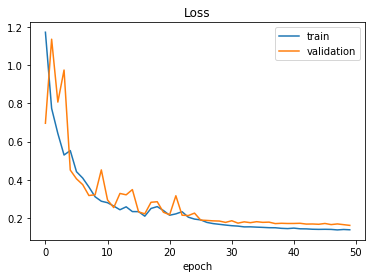

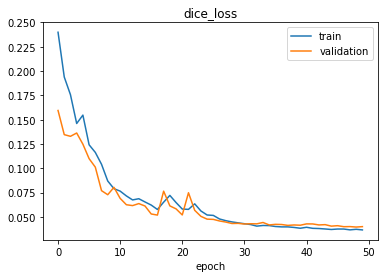

In [19]:
# plot loss during training
plt.title('Loss')
#train_loss = history.history['loss']
#test_loss = history.history['val_loss']
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.legend()
#plt.show()
plt.savefig('result_loss.png')

# plot dice_loss during training
plt.figure()
plt.title('dice_loss')
plt.plot(history.history['dice_loss'], label='train')
plt.plot(history.history['val_dice_loss'], label='validation')
plt.xlabel('epoch')
plt.legend()
#plt.show()
plt.savefig('result_dice.png')

#plt.savefig('result.png')